In [90]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [91]:
%matplotlib_inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from pandas.plotting import register_matplotlib_converters

UsageError: Line magic function `%matplotlib_inline` not found.


In [92]:
import seaborn as sns
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12, 8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

In [93]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [94]:
from numpy import sqrt
from sklearn.metrics import mean_squared_error

In [95]:
# Deployment:
import pickle

# Modelo

## DataFrame:

In [96]:
path = r'../../data/customers/CASTING_DB106.csv'
df = pd.read_csv(
    filepath_or_buffer=path,
    parse_dates=['VUF_DT'],
    index_col='VUF_DT',
    usecols=['VUF_DT', 'VUF_VLRLIQFINAL']
)

In [97]:
df.head(3)

,VUF_VLRLIQFINAL
VUF_DT,
2023-05-10,152.0
2023-05-15,55.0
2023-06-22,45900.0


## Código:

In [98]:
class Casting:
    def adf_test(self, data):
        dftest = adfuller(data, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['teste', 'valor p', '# de lags', '# de observação'])
        
        for key, value in dftest[4].items():
            dfoutput[f'valor crítico ({key})'] = value
        
        print('Resultado do Teste Dickey-Fuller')
        print(dfoutput)

if __name__ == '__main__':
    casting = Casting()

## Preparação Dos Dados:

### Agrupando por mês:

In [99]:
serie = (
    df.groupby(
        (df.index).to_period("M")
    )['VUF_VLRLIQFINAL'].sum()
)

### Removendo o mês de outubro:

In [100]:
serie = serie.drop(serie.index[-1])

### Convertendo para datetime:

In [101]:
serie.index = serie.index.to_timestamp()

### Precheendo valores faltantes com interpolação:

In [102]:
# Adiciona todas as datas mensais entre a primeira e a última data
all_dates = pd.date_range(start=serie.index.min(), end=serie.index.max(), freq='MS')
serie = serie.reindex(all_dates)

# Interpola os valores faltantes
serie = serie.interpolate(method='linear')

# Exibe o DataFrame interpolado
print(serie)


2022-04-01    228729.30
2022-05-01    397304.29
2022-06-01      3338.14
2022-07-01      2925.33
2022-08-01    110881.09
2022-09-01    225741.67
2022-10-01    225741.67
2022-11-01    225741.67
2022-12-01    225741.67
2023-01-01        71.00
2023-02-01      3691.07
2023-03-01      7311.14
2023-04-01     10931.21
2023-05-01     14551.28
2023-06-01     76618.90
2023-07-01     51784.56
2023-08-01     26950.22
2023-09-01      2115.88
Freq: MS, Name: VUF_VLRLIQFINAL, dtype: float64


### Exibindo Serie:

In [103]:
serie

2022-04-01    228729.30
2022-05-01    397304.29
2022-06-01      3338.14
2022-07-01      2925.33
2022-08-01    110881.09
2022-09-01    225741.67
2022-10-01    225741.67
2022-11-01    225741.67
2022-12-01    225741.67
2023-01-01        71.00
2023-02-01      3691.07
2023-03-01      7311.14
2023-04-01     10931.21
2023-05-01     14551.28
2023-06-01     76618.90
2023-07-01     51784.56
2023-08-01     26950.22
2023-09-01      2115.88
Freq: MS, Name: VUF_VLRLIQFINAL, dtype: float64

### Descrição dos dados:

In [104]:
serie.describe()

count        18.000000
mean     102231.671667
std      120751.775273
min          71.000000
25%        4596.087500
50%       39367.390000
75%      225741.670000
max      397304.290000
Name: VUF_VLRLIQFINAL, dtype: float64

## Visualização Dos Dados:

### Gráfico de linha - Valor Líquido de Venda:

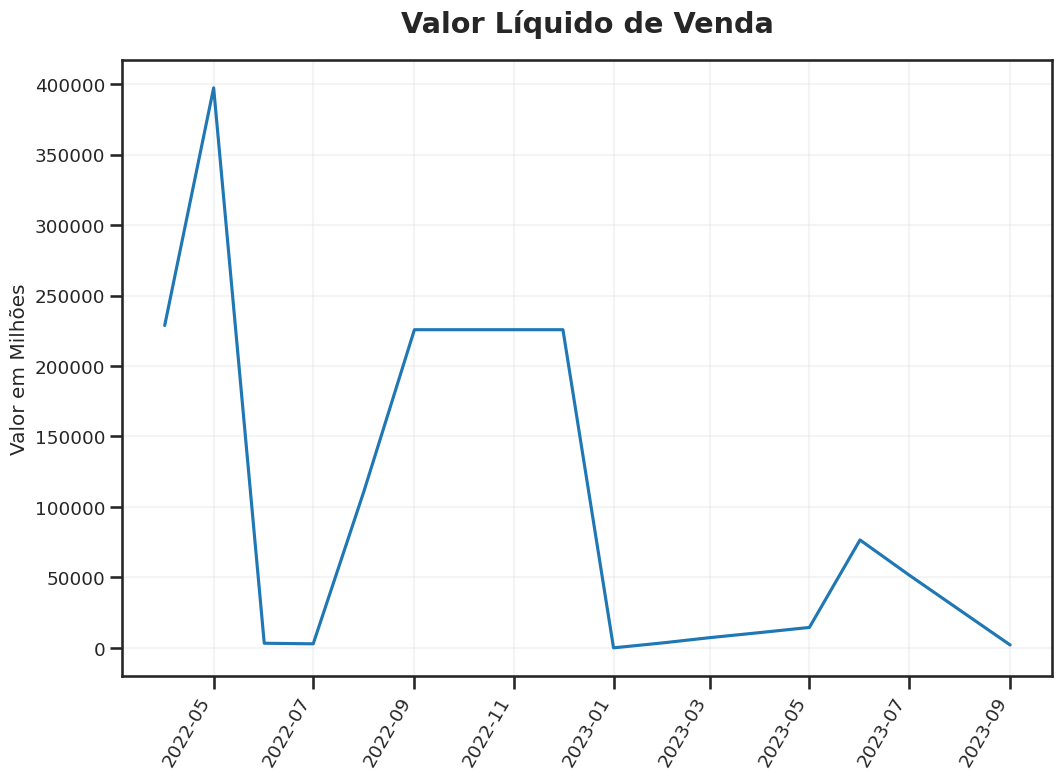

In [105]:
# register_matplotlib_converters()
plt.plot(serie)
plt.xticks(rotation=60, ha='right')
plt.ylabel('Valor em Milhões')
plt.title('Valor Líquido de Venda')
plt.show()

### Teste de Adfuller:

O Teste de ADF (Augmented Dickey-Fuller) é um teste estatístico comum usado para testar se uma série temporal é estacionária ou não 1. Ele pertence a uma categoria de testes chamada ‘Teste de Raiz Unitária’, que é o método adequado para testar a estacionariedade de uma série temporal 1.

O teste ADF testa a hipótese nula de que uma raiz unitária está presente em uma amostra de série temporal 1. Uma raiz unitária é uma característica de uma série temporal que a torna não estacionária 1. A presença de uma raiz unitária significa que a série temporal é não estacionária 1. O número de raízes unitárias contidas na série corresponde ao número de operações de diferenciação necessárias para tornar a série estacionária 1.

O teste ADF é fundamentalmente um teste de significância estatística 1. Isso significa que há um teste de hipótese envolvido com uma hipótese nula e alternativa, e como resultado, uma estatística de teste é calculada e os valores p são relatados 1. A partir da estatística de teste e do valor p, é possível fazer uma inferência sobre se uma determinada série é estacionária ou não.

O valor p é um resultado do Teste de ADF que é usado para testar se uma série temporal é estacionária ou não. O valor p é a probabilidade de obter uma estatística de teste tão extrema quanto a observada, assumindo que a hipótese nula é verdadeira. Em outras palavras, o valor p é uma medida da evidência contra a hipótese nula.

Se o valor p for menor do que o nível de significância escolhido (geralmente 0,05), então a hipótese nula é rejeitada e a série é considerada estacionária. Por outro lado, se o valor p for maior do que o nível de significância, então a hipótese nula não é rejeitada e a série é considerada não estacionária.

In [106]:
adf = adfuller(serie)

In [107]:
print(f'ADF Estatística: {adf[0]}')
print(f'Valor de P: {adf[1]}')
print(f'Valores Críticos:')
for key, value, in adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Estatística: -2.299195035798451
Valor de P: 0.17222771992587343
Valores Críticos:
	1%: -4.223
	5%: -3.189
	10%: -2.730


In [108]:
casting.adf_test(serie)

Resultado do Teste Dickey-Fuller
teste                  -2.299195
valor p                 0.172228
# de lags               6.000000
# de observação        11.000000
valor crítico (1%)     -4.223238
valor crítico (5%)     -3.189369
valor crítico (10%)    -2.729839
dtype: float64


### Decomposição sazonal:

O seasonal_decompose é uma função do pacote statsmodels que permite decompor uma série temporal em suas componentes de tendência, sazonalidade e resíduo. A decomposição sazonal é útil para entender a variação sazonal em uma série temporal, como a demanda por produtos sazonais ou a variação sazonal na temperatura.

#### modelo aditivo:

No modelo aditivo, a série temporal é decomposta em três componentes: tendência, sazonalidade e resíduo. A equação para o modelo aditivo é dada por:

***Y[t]=T[t]+S[t]+e[t]***

onde Y[t]Y[t] é o valor da série temporal no tempo tt, T[t]T[t] é a componente de tendência, S[t]S[t] é a componente sazonal e e[t]e[t] é o erro aleatório.

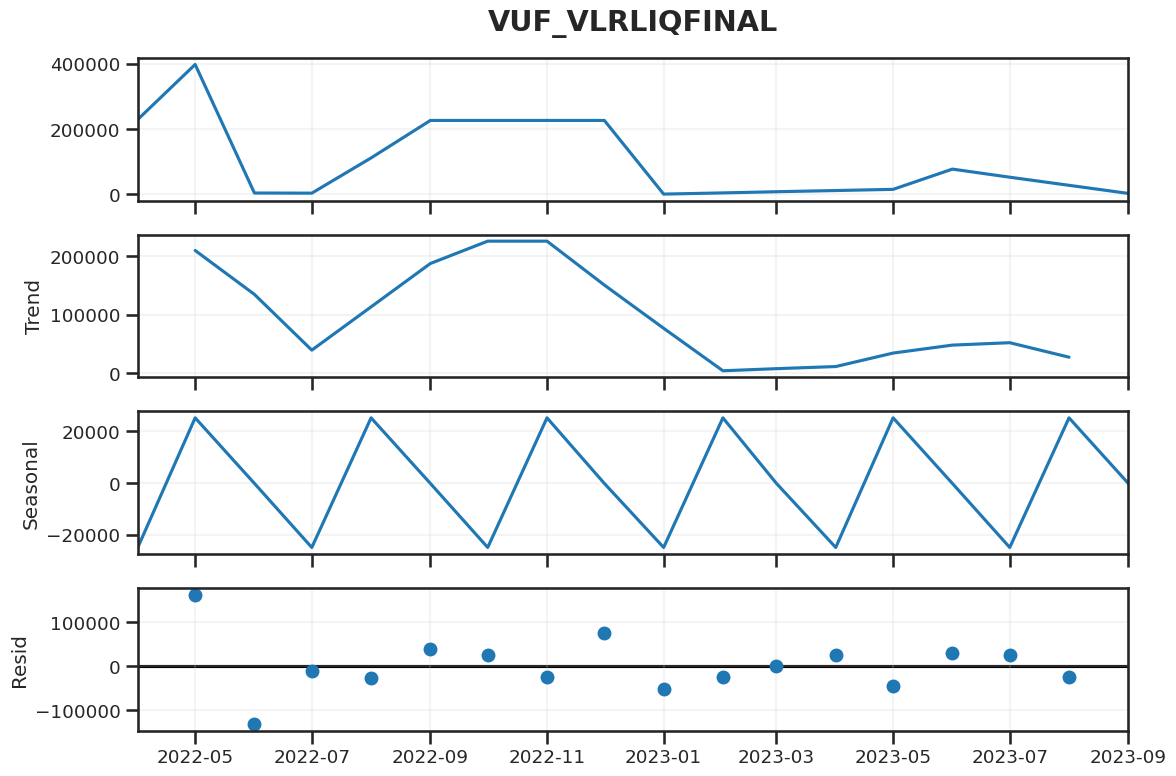

In [109]:
sd = seasonal_decompose(serie, period=3, model='aditive')
sd.plot()
plt.show()

#### modelo multiplicativo:

No modelo multiplicativo, a série temporal é decomposta em três componentes: tendência, sazonalidade e resíduo. A equação para o modelo multiplicativo é dada por:

***Y[t]=T[t]∗S[t]∗e[t]***

onde Y[t]Y[t] é o valor da série temporal no tempo tt, T[t]T[t] é a componente de tendência, S[t]S[t] é a componente sazonal e e[t]e[t] é o erro aleatório.

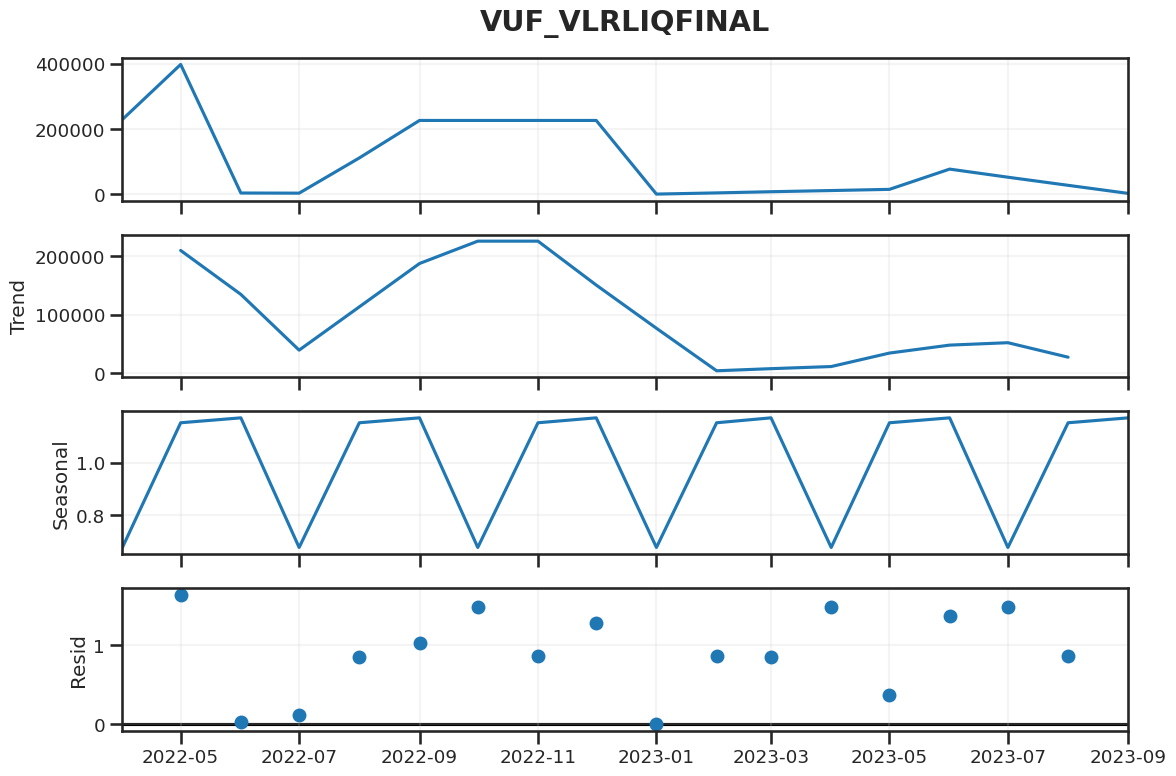

In [110]:
sd = seasonal_decompose(serie, period=3, model='multiplicative')
sd.plot()
plt.show()

### ACF:

O gráfico ACF (Autocorrelation Function) é um gráfico utilizado em séries temporais para traçar as autocorrelações em diversas defasagens. A análise desse gráfico permite entender se a série é aleatória ou possui alguma tendência ou sazonalidade.

A função de autocorrelação é uma medida da correlação entre as observações de uma série temporal que são separadas por k unidades de tempo. Use a função de autocorrelação e as funções de autocorrelação parcial em conjunto para identificar modelos ARIMA. Examine os picos em cada lag para determinar se eles são significativos. Um pico significativo se estenderá para além dos limites de significância, o que indica que a correlação para esse lag não é igual a zero.

Por exemplo, se a série temporal apresenta um padrão de autocorrelação significativo em um lag de 12 meses, isso pode indicar que a série apresenta um padrão sazonal anual. O gráfico ACF pode ajudar a identificar esses padrões e a escolher o modelo de previsão mais adequado para a série temporal em questão

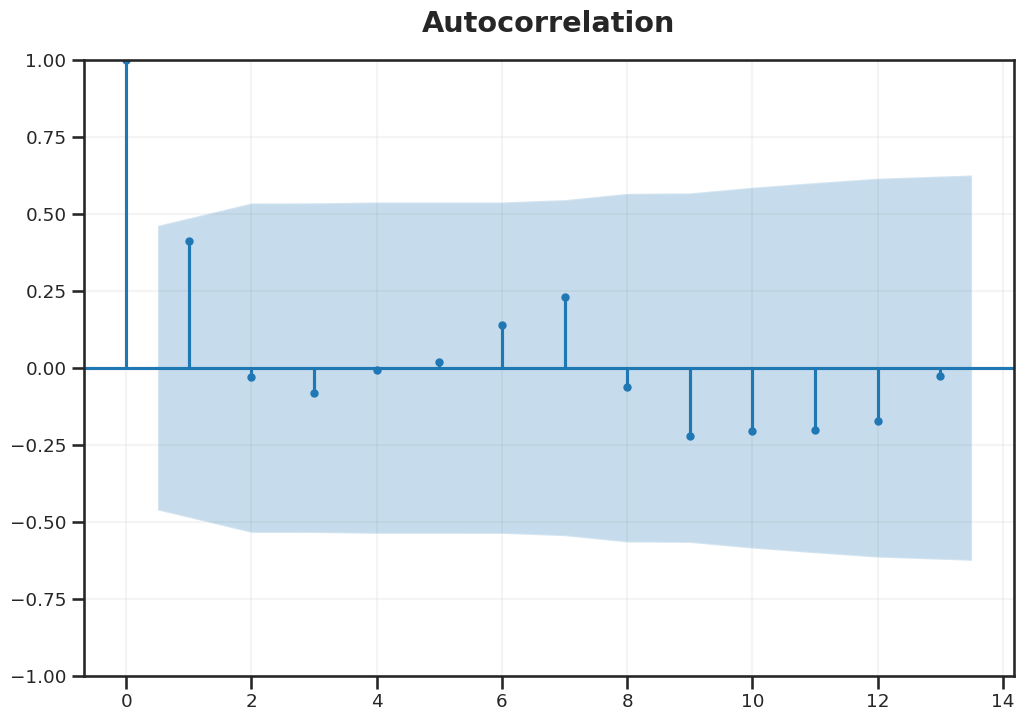

In [111]:
plot_acf(serie)
plt.show()

### PACF:

O gráfico PACF (Partial Autocorrelation Function) é um gráfico utilizado em séries temporais para traçar as autocorrelações parciais em diversas defasagens. A análise desse gráfico permite entender se a série é aleatória ou possui alguma tendência ou sazonalidade.

A função de autocorrelação parcial é uma medida da correlação entre as observações de uma série temporal que são separadas por k unidades de tempo, após o ajuste para a presença de todos os outros termos de menor lag. Use as funções de autocorrelação parcial e autocorrelação em conjunto para identificar modelos ARIMA. Procure pelos seguintes padrões na função de autocorrelação parcial. Examine os picos em cada lag para determinar se eles são significativos. Um pico significativo se estenderá para além dos limites de significância, o que indica que a correlação para esse lag não é igual a zero.

O gráfico PACF é uma ferramenta útil para identificar a ordem do termo auto-regressivo em um modelo ARIMA. Se houver um pico significativo no lag 1, isso pode indicar que um modelo ARIMA (p,0,0) é apropriado. Se houver um pico significativo no lag 2, isso pode indicar que um modelo ARIMA (0,0,q) é apropriado. Se houver picos significativos em ambos os lags 1 e 2, isso pode indicar que um modelo ARIMA (p,0,q) é apropriado.

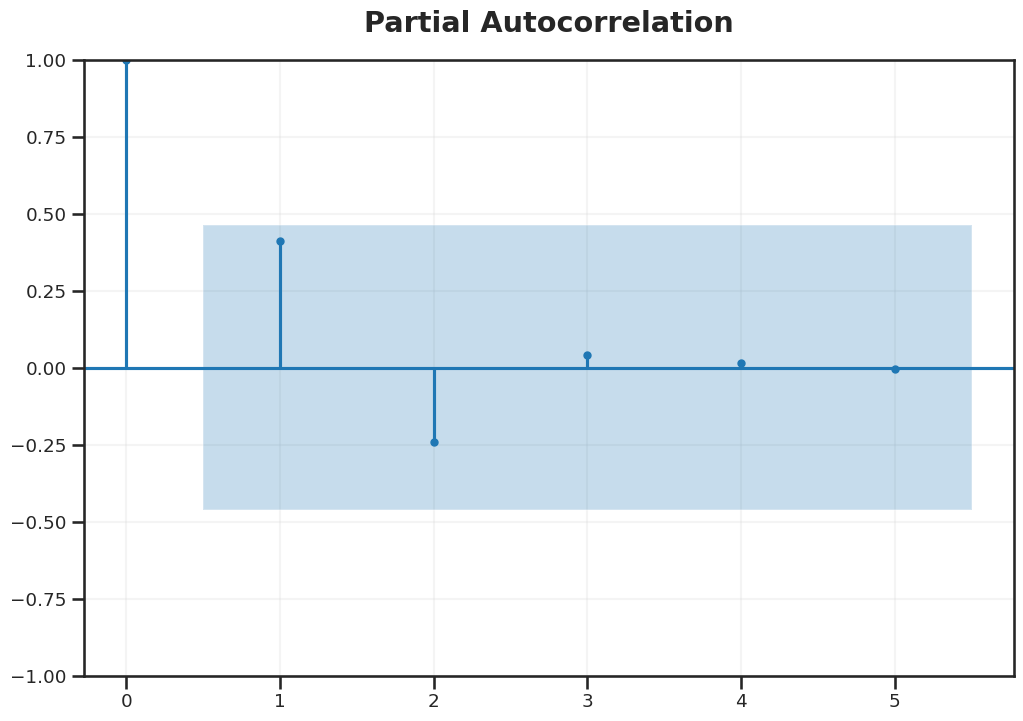

In [112]:
plot_pacf(serie, lags=5)
plt.show()

## Modelo:

### Separando Treino e Teste:

In [113]:
tamanho_treino = int(len(serie) * 0.69)
treino, teste = serie[0:tamanho_treino], serie[tamanho_treino:len(serie)]
teste = teste.reset_index(drop=True)

### ARIMA:

Método estatístico que utiliza autoregressão e médias móveis para previsão de séries temporais. Um modelo linear é construído incluindo um número especificado de termos e os dados são preparados por um nível de diferenciação afim de tornar este estacionário.

Podemos usar um valor 0 para desligar um parâmetro, dessa forma, aquela função em questão não será feita, por exemplo, se no parâmetro d definirmos 0 não será realizada uma diferenciação nos dados. Neste exemplo teríamos um modelo **ARMA**.

---

*   **AR**: *Autoregression* : Um modelo que usa a relação dependende entre uma observação e alguns lags.

*   **I**: *Integrated*  : Uso de diferenciação nas observações brutas, exemplo: subtração do valor de uma observação com sua observação anterior. O objetivo é transformar a série temporal em estacionária.

*  **MA**: *Moving Average* : Um modelo que usa a dependência entre a observação e o erro residual a partir de um modelo de média móvel aplicado a lags.

          residual error = expected − predicted
    
- Isso é diferente de **Moving Average Smoothing.**
- Erros residuais contém estruturas temporais que podem ser modeladas.
- Existem sinais complexos nos erros residuais.
- Um modelo que prever o erro residual pode ser usado para ajustar os próximos erros e melhorar um modelo que aprende com o histórico.




---

O modelo arima contém alguns parâmetros


```
# ARIMA(p,d,q)
```
*   **p:** O número de lags que foram devem ser incluídos no modelo.
*   **d:** O número de vezes que as observações serão diferenciadas.
*   **q:** O tamanho de uma janela de média móvel. Também chamada de ordem de média móvel.

In [114]:
pdm = auto_arima(
    y=serie,
    start_p=0,
    start_q=0,
    d=1,
    trace=True,
    max_p=5,
    max_q=5,
    seasonal=False,
    stepwise=False,
    error_action='ignore',
)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=451.045, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=461.982, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=465.864, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=456.278, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=453.436, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=458.437, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=459.101, Time=0.04 

In [115]:
model = ARIMA(serie, order=(0,1,0))

### Treinando o modelo:

In [116]:
model_fit = model.fit()

### Realizando Previsão:

In [117]:
model_fit.forecast()

2023-10-01    2115.88
Freq: MS, dtype: float64

### Analisando Modelo:

In [118]:
predictions = model_fit.predict(n_periods=1)

In [119]:
print(predictions)

2022-04-01         0.00
2022-05-01    228729.30
2022-06-01    397304.29
2022-07-01      3338.14
2022-08-01      2925.33
2022-09-01    110881.09
2022-10-01    225741.67
2022-11-01    225741.67
2022-12-01    225741.67
2023-01-01    225741.67
2023-02-01        71.00
2023-03-01      3691.07
2023-04-01      7311.14
2023-05-01     10931.21
2023-06-01     14551.28
2023-07-01     76618.90
2023-08-01     51784.56
2023-09-01     26950.22
Freq: MS, Name: predicted_mean, dtype: float64


### Resumo do modelo:

In [120]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        VUF_VLRLIQFINAL   No. Observations:                   18
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -223.634
Date:                Sat, 30 Dec 2023   AIC                            449.269
Time:                        11:32:51   BIC                            450.102
Sample:                    04-01-2022   HQIC                           449.351
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.473e+10   2.82e+09      5.225      0.000     9.2e+09    2.03e+10
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):                14.69
Prob(Q):                              0.30   Pr

### Avaliando os resultados (RMSE):

In [121]:
rmse = sqrt(mean_squared_error(serie, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 132806.001


### Analisando desempenho do modelo:

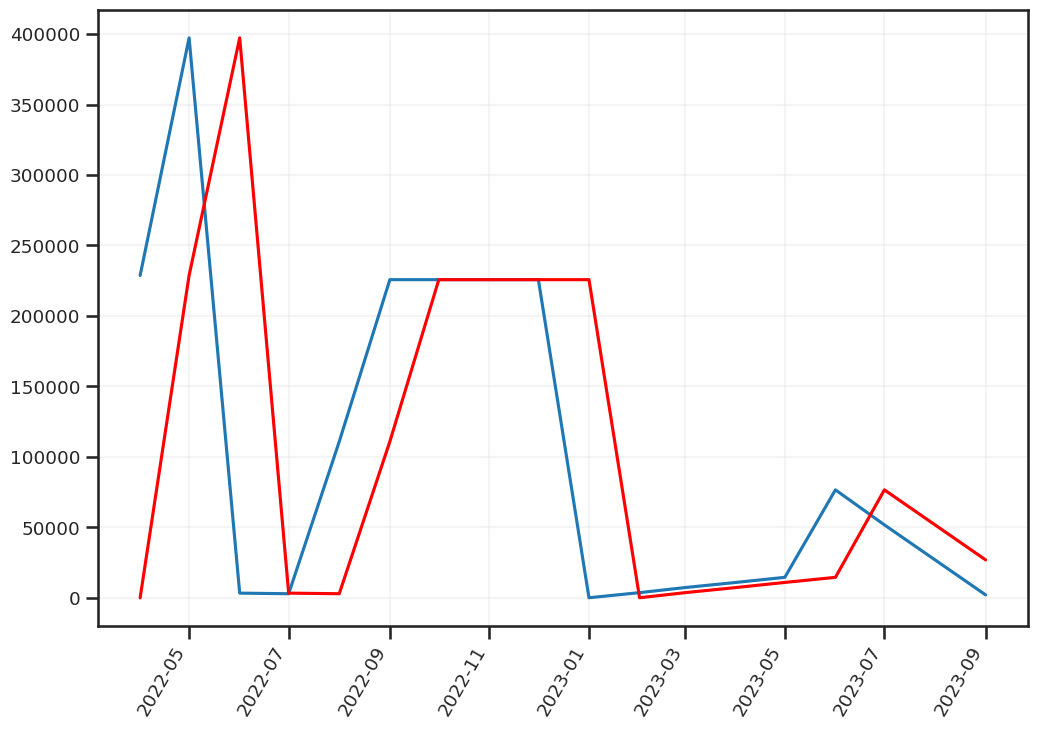

In [122]:
plt.plot(serie)
plt.plot(predictions, color='red')
# plt.plot(model_fit.forecasts(), color='green')

plt.xticks(rotation=60, ha='right')
plt.show()

### Análise de resíduos:

In [123]:
residuals = pd.DataFrame(model_fit.resid)

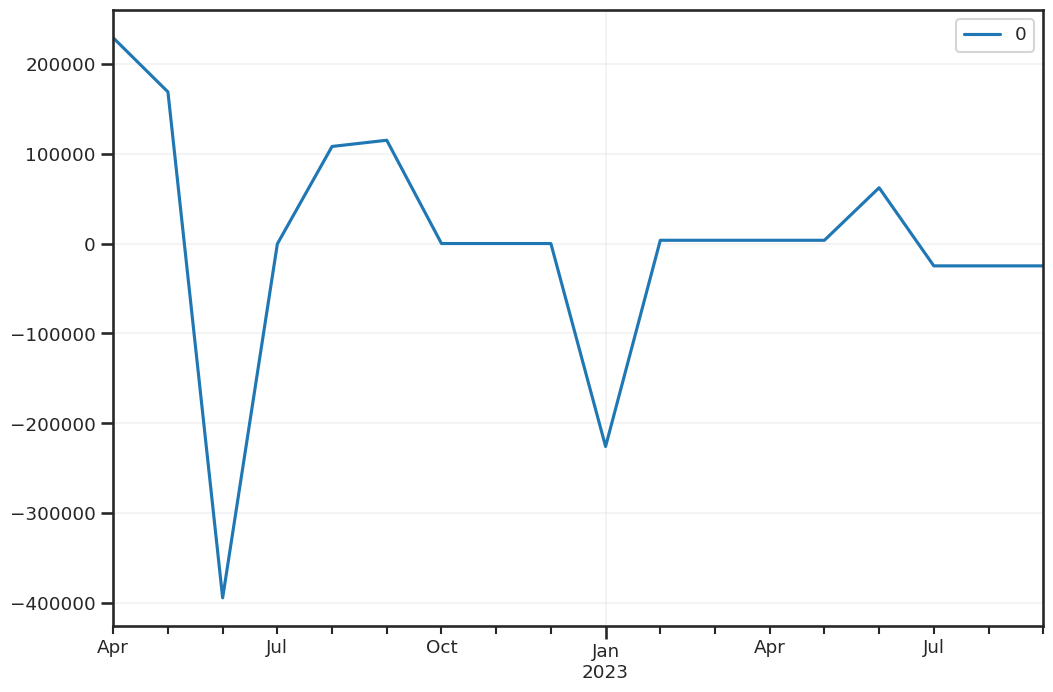

In [124]:
residuals.plot()
plt.show()

#### Densidade dos residuais:

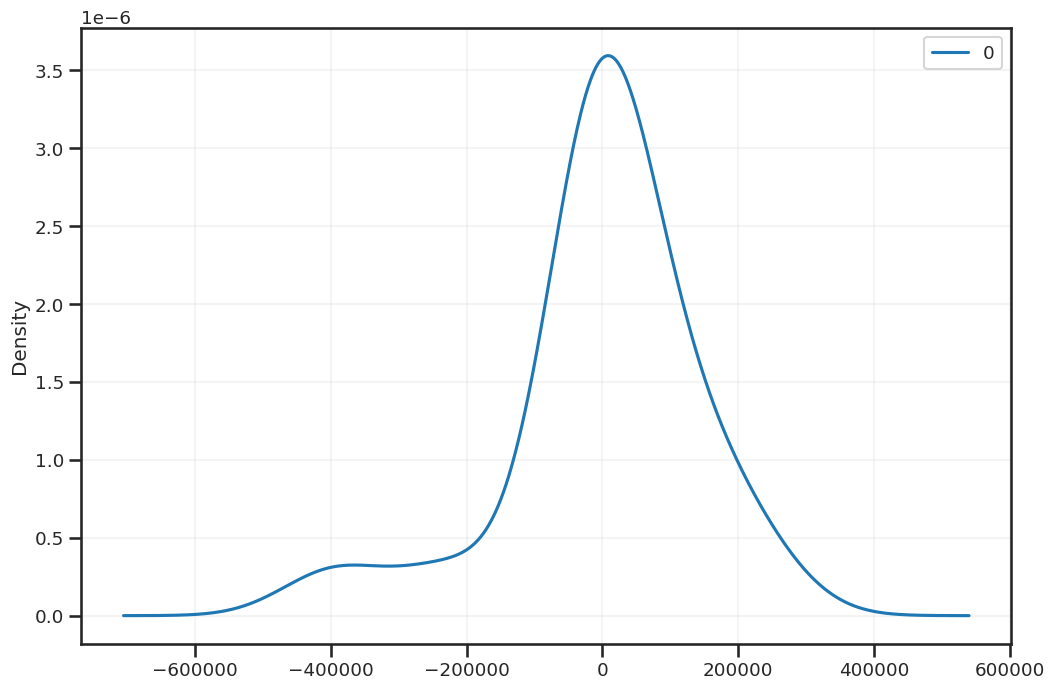

In [125]:
residuals.plot(kind='kde')
plt.show()

### Histograma dos resíduos:

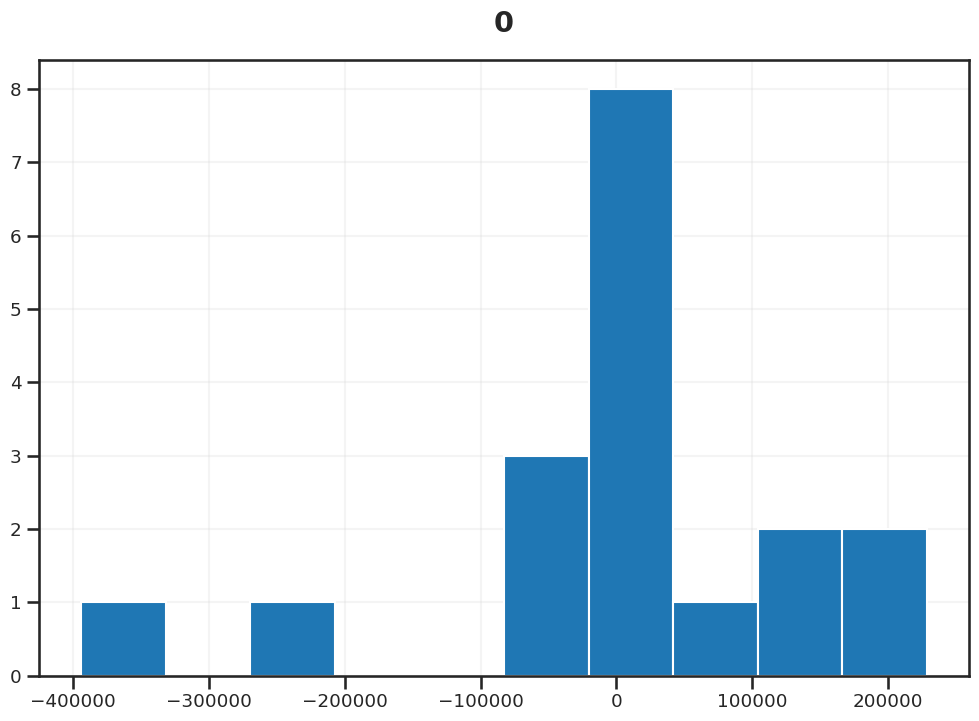

In [126]:
residuals.hist(ax=plt.gca())
plt.show()

### Primeiras 5 linhas dos resíduos:

In [127]:
residuals.head()

,0
2022-04-01,228729.30
2022-05-01,168574.99
2022-06-01,-393966.15
2022-07-01,-412.81
2022-08-01,107955.76


#### Estatística descritiva dos resíduos:

In [128]:
display(residuals.describe())

,0
count,18.000000
mean,117.548889
std,136656.194116
min,-393966.150000
25%,-18728.957500
50%,1810.035000
75%,47455.732500
max,228729.300000


### Verificando autocorrelação dos resíduos:

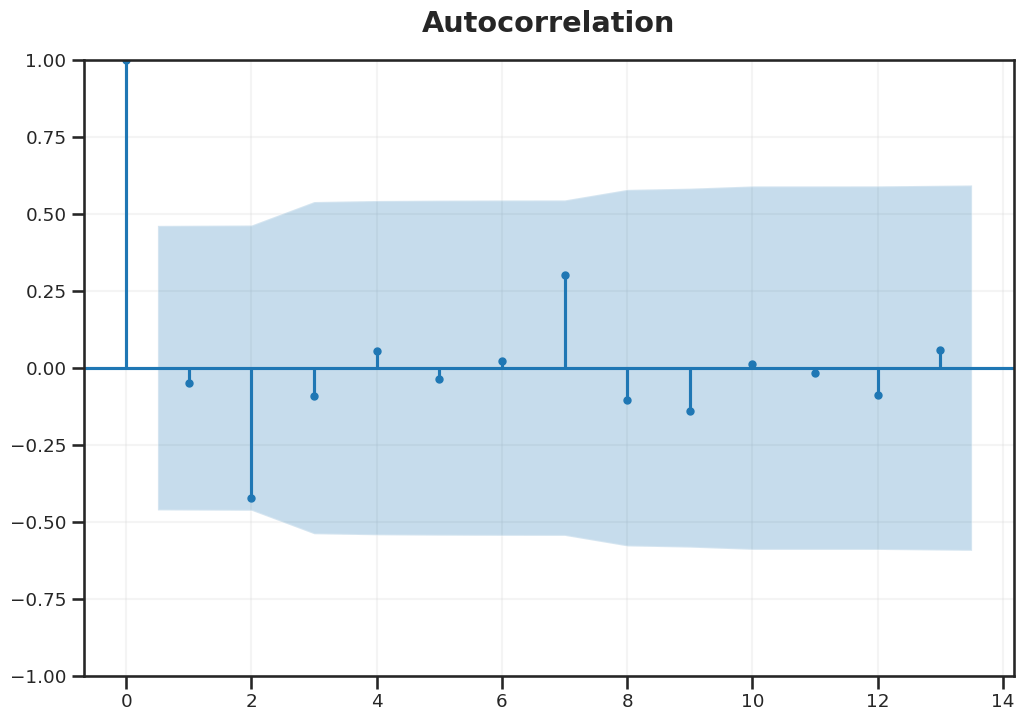

In [129]:
plot_acf(residuals, ax=plt.gca())
plt.show()


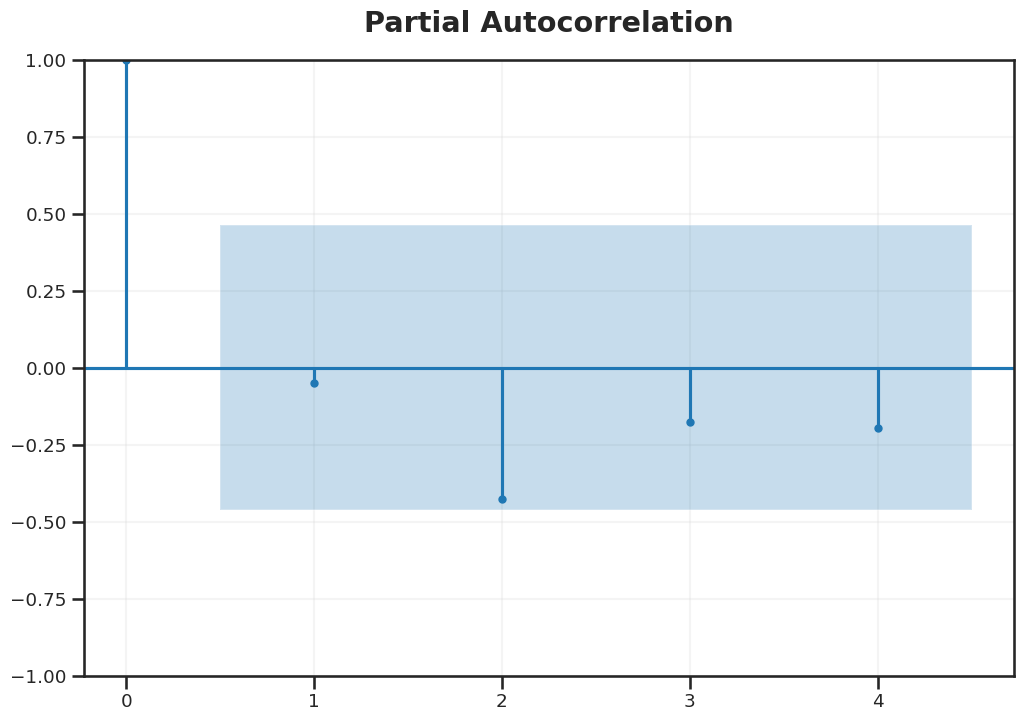

In [130]:
plot_pacf(residuals, ax=plt.gca(), lags=4)
plt.show()

### Deployment:

In [131]:
path = r'../../models/DB106.pkl' 

with open(path, 'wb') as file:
    pickle.dump(model_fit, file)